## Homework3 

James Guan

Netid: sg7993

# Sequential Structure

For a 100MM pool of 6.5% WAC 30yr loans with 70bps servicing/g-fee, create a Sequential structure with 4 tranches:

A: 45MM, B: 25MM, C: 20MM, D: 10MM.

Let us first define PSA function for convenience.

In [1]:
import pandas as pd
import math
# Set display option to not use scientific notation
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
class PSA:
    
    def __init__(self, speed: float):
        self._speed = speed
        self.end_CPR = 0.06 * speed/100
        
    @property
    def speed(self):
        return self._speed
    
    def CPR(self, month_index: int):
        return min(self.end_CPR,  0.002 + (self.end_CPR - 0.002)/30 * month_index) 
    
    def SMM(self, month_index: int):
        smm = 1 - (1 - self.CPR(month_index))**(1/12)
        # print(smm)
        return smm

## PSA100 (Code Demo)

Demonstrate the Sequential Structure with PSA100 and assume that the loans are fixed-rate.

In [3]:
from homework_utils.previous_homework_func import *

def cal_monthly_interest_payment(balance: float, WAC: float) -> float:
    return balance * WAC / 12

def cal_scheduled_balance(previous_balance: float, scheduled_principal_payment: float) -> float:
    return previous_balance - scheduled_principal_payment

def cal_prepayment(scheduled_balance: float, smm: float) -> float:
    return scheduled_balance * smm

def cal_actual_balance(previous_balance: float, scheduled_principal_payment: float, prepayment: float) -> float:
    return previous_balance - scheduled_principal_payment - prepayment

In [4]:
principal = 100_000_000
WAC = 0.065
N = 30 * 12
scheduled_payment = calcualte_monthly_payment(principal, WAC, N)    
psa100 = PSA(100)
print(f"Monthly Payment: {round(scheduled_payment, 2)}")

Monthly Payment: 632068.02


Now let us iterate the code above to generate the cashflow based on PSA 100 prepayment model. 

In [5]:
balance = principal
i = 0
balances = [balance]
interest_expenses = [0]
scheduled_principal_payments = [0]
unscheduled_principal_payments = [0]
month_indices = [i]
scheduled_payment = calcualte_monthly_payment(balance, WAC, N)

while balance > 0:
    i += 1
    month_indices.append(i)
    interest_payment = cal_monthly_interest_payment(balance, WAC)
    scheduled_principal_payment = scheduled_payment - interest_payment
    if balance < scheduled_principal_payment:
        scheduled_principal_payment = balance
        actual_balance = 0
        unscheduled_principal_payment = 0
    else:
        smm = psa100.SMM(i)
        prepayment = cal_prepayment(scheduled_balance=balance - scheduled_principal_payment, smm=smm)
        unscheduled_principal_payment = prepayment
        actual_balance = cal_actual_balance(previous_balance=balance, scheduled_principal_payment=scheduled_principal_payment, prepayment=prepayment)
        
    balance = actual_balance
    balances.append(balance)
    interest_expenses.append(interest_payment)
    scheduled_principal_payments.append(scheduled_principal_payment)
    unscheduled_principal_payments.append(unscheduled_principal_payment)
    scheduled_payment = scheduled_payment * (1 - smm)

In [6]:
result = pd.DataFrame({
    "Month": month_indices[1:],
    "Beginning Balance": balances[:-1],
    "Scheduled Principal Payments": scheduled_principal_payments[1:],
    "Unscheduled Principal Payments": unscheduled_principal_payments[1:],
    "Interest Expense": interest_expenses[1:],
    "Unpaid Balance": balances[1:],
    "Paid Principal": [100_000_000 - x for x in balances[1:]]
})
result.set_index("Month", inplace=True)
result

,Beginning Balance,Scheduled Principal Payments,Unscheduled Principal Payments,Interest Expense,Unpaid Balance,Paid Principal
Month,,,,,,
1,100000000.0000,90401.3568,32807.3326,541666.6667,99876791.3105,123208.6895
2,99876791.3105,90861.1849,48915.9017,540999.2863,99737014.2239,262985.7761
3,99737014.2239,91308.5675,65002.4209,540242.1604,99580703.2355,419296.7645
4,99580703.2355,91743.2691,81058.8520,539395.4759,99407901.1144,592098.8856
5,99407901.1144,92165.0589,97077.1586,538459.4644,99218658.8968,781341.1032
...,...,...,...,...,...,...
356,536394.6962,106123.0289,2212.8927,2905.4713,428058.7746,99571941.2254
357,428058.7746,106149.1135,1655.5855,2318.6517,320254.0757,99679745.9243
358,320254.0757,106175.2045,1101.0104,1734.7096,212977.8608,99787022.1392


In [7]:
tranches = {
    'A': 45e6,
    'B': 25e6,
    'C': 20e6,
    'D': 10e6
}

# Initialize the remaining balances for the tranches
remaining_balances = tranches.copy()


def apply_sequential_payments(row):
    global remaining_balances
    total_payment = row['Scheduled Principal Payments'] + row['Unscheduled Principal Payments']
    for tranche, balance in remaining_balances.items():
        if total_payment > 0:
            if total_payment >= balance:
                total_payment -= balance
                remaining_balances[tranche] = 0
            else:
                remaining_balances[tranche] -= total_payment
                total_payment = 0
        else:
            break
    row['Tranche A Remaining'] = remaining_balances['A']
    row['Tranche B Remaining'] = remaining_balances['B']
    row['Tranche C Remaining'] = remaining_balances['C']
    row['Tranche D Remaining'] = remaining_balances['D']
    return row

# Apply the function to each row of the DataFrame
result = result.apply(apply_sequential_payments, axis=1)
result # Display the first few rows of the DataFrame to check the results

,Beginning Balance,Scheduled Principal Payments,Unscheduled Principal Payments,Interest Expense,Unpaid Balance,Paid Principal,Tranche A Remaining,Tranche B Remaining,Tranche C Remaining,Tranche D Remaining
Month,,,,,,,,,,
1,100000000.0000,90401.3568,32807.3326,541666.6667,99876791.3105,123208.6895,44876791.3105,25000000.0000,20000000.0000,10000000.0000
2,99876791.3105,90861.1849,48915.9017,540999.2863,99737014.2239,262985.7761,44737014.2239,25000000.0000,20000000.0000,10000000.0000
3,99737014.2239,91308.5675,65002.4209,540242.1604,99580703.2355,419296.7645,44580703.2355,25000000.0000,20000000.0000,10000000.0000
4,99580703.2355,91743.2691,81058.8520,539395.4759,99407901.1144,592098.8856,44407901.1144,25000000.0000,20000000.0000,10000000.0000
5,99407901.1144,92165.0589,97077.1586,538459.4644,99218658.8968,781341.1032,44218658.8968,25000000.0000,20000000.0000,10000000.0000
...,...,...,...,...,...,...,...,...,...,...
356,536394.6962,106123.0289,2212.8927,2905.4713,428058.7746,99571941.2254,0.0000,0.0000,0.0000,428058.7746
357,428058.7746,106149.1135,1655.5855,2318.6517,320254.0757,99679745.9243,0.0000,0.0000,0.0000,320254.0757
358,320254.0757,106175.2045,1101.0104,1734.7096,212977.8608,99787022.1392,0.0000,0.0000,0.0000,212977.8608


<Axes: xlabel='Month'>

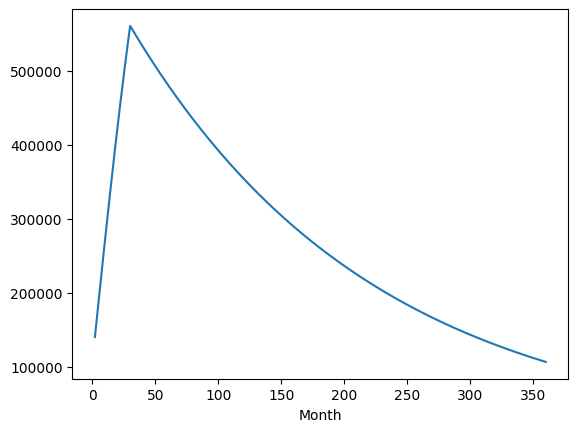

In [8]:
result['Paid Principal'].diff().plot()

Based on the table above, we can see that the tranches are paid sequentially.

Now, let us calculate WAL for each tranche.

In [9]:
A_all_balances = [45e6]+result['Tranche A Remaining'].tolist()
A_all_principal_payments = [previous_balance - current_balance for previous_balance, current_balance in zip(A_all_balances[:-1], A_all_balances[1:] + [0])]

#:param all_principal_payments_list: a list of principal payments for each loan from 0 to n (0 is the first principal payment)
#:param all_balances_list: a list of balances for each loan from 0 to n (principal balance at time 0 is the original loan amount)
trancheA_WALs = []

for month_index in month_indices:
    wal = calculate_WAL(all_principal_payments_list=[A_all_principal_payments], all_balances_list=[A_all_balances],k=month_index)
    trancheA_WALs.append(wal)

trancheA_WAL = trancheA_WALs[0]
trancheA_WALs = pd.Series(trancheA_WALs[1:], index=month_indices[1:])

B_all_balances = [25e6]+result['Tranche B Remaining'].tolist()
B_all_principal_payments = [previous_balance - current_balance for previous_balance, current_balance in zip(B_all_balances[:-1], B_all_balances[1:] + [0])]
trancheB_WALs = []
for month_index in month_indices:
    wal = calculate_WAL(all_principal_payments_list=[B_all_principal_payments], all_balances_list=[B_all_balances],k=month_index)
    trancheB_WALs.append(wal)

trancheB_WAL = trancheB_WALs[0]
trancheB_WALs = pd.Series(trancheB_WALs[1:], index=month_indices[1:])

C_all_balances = [20e6]+result['Tranche C Remaining'].tolist()
C_all_principal_payments = [previous_balance - current_balance for previous_balance, current_balance in zip(C_all_balances[:-1], C_all_balances[1:] + [0])]
trancheC_WALs = []

for month_index in month_indices:
    wal = calculate_WAL(all_principal_payments_list=[C_all_principal_payments], all_balances_list=[C_all_balances],k=month_index)
    trancheC_WALs.append(wal)

trancheC_WAL = trancheC_WALs[0]
trancheC_WALs = pd.Series(trancheC_WALs[1:], index=month_indices[1:])

D_all_balances = [10e6]+result['Tranche D Remaining'].tolist()
D_all_principal_payments = [previous_balance - current_balance for previous_balance, current_balance in zip(D_all_balances[:-1], D_all_balances[1:] + [0])]
trancheD_WALs = []

for month_index in month_indices:
    wal = calculate_WAL(all_principal_payments_list=[D_all_principal_payments], all_balances_list=[D_all_balances],k=month_index)
    trancheD_WALs.append(wal)

trancheD_WAL = trancheD_WALs[0]
trancheD_WALs = pd.Series(trancheD_WALs[1:], index=month_indices[1:])

In [10]:
result['Tranche A WAL'] = trancheA_WALs
result['Tranche B WAL'] = trancheB_WALs
result['Tranche C WAL'] = trancheC_WALs
result['Tranche D WAL'] = trancheD_WALs
result

,Beginning Balance,Scheduled Principal Payments,Unscheduled Principal Payments,Interest Expense,Unpaid Balance,Paid Principal,Tranche A Remaining,Tranche B Remaining,Tranche C Remaining,Tranche D Remaining,Tranche A WAL,Tranche B WAL,Tranche C WAL,Tranche D WAL
Month,,,,,,,,,,,,,,
1,100000000.0000,90401.3568,32807.3326,541666.6667,99876791.3105,123208.6895,44876791.3105,25000000.0000,20000000.0000,10000000.0000,4.3712,11.6269,18.9433,26.4414
2,99876791.3105,90861.1849,48915.9017,540999.2863,99737014.2239,262985.7761,44737014.2239,25000000.0000,20000000.0000,10000000.0000,4.3015,11.5436,18.8600,26.3581
3,99737014.2239,91308.5675,65002.4209,540242.1604,99580703.2355,419296.7645,44580703.2355,25000000.0000,20000000.0000,10000000.0000,4.2332,11.4602,18.7766,26.2748
4,99580703.2355,91743.2691,81058.8520,539395.4759,99407901.1144,592098.8856,44407901.1144,25000000.0000,20000000.0000,10000000.0000,4.1664,11.3769,18.6933,26.1914
5,99407901.1144,92165.0589,97077.1586,538459.4644,99218658.8968,781341.1032,44218658.8968,25000000.0000,20000000.0000,10000000.0000,4.1009,11.2936,18.6100,26.1081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,536394.6962,106123.0289,2212.8927,2905.4713,428058.7746,99571941.2254,0.0000,0.0000,0.0000,428058.7746,0.0000,0.0000,0.0000,0.1245
357,428058.7746,106149.1135,1655.5855,2318.6517,320254.0757,99679745.9243,0.0000,0.0000,0.0000,320254.0757,0.0000,0.0000,0.0000,0.0831
358,320254.0757,106175.2045,1101.0104,1734.7096,212977.8608,99787022.1392,0.0000,0.0000,0.0000,212977.8608,0.0000,0.0000,0.0000,0.0416


However, when we are plotting the WAL for each tranche, we are using the WAL at WALA = 0. 

In [11]:
print("At PSA100:")
print(f"Tranche A WAL: {trancheA_WAL}")
print(f"Tranche B WAL: {trancheB_WAL}")
print(f"Tranche C WAL: {trancheC_WAL}")
print(f"Tranche D WAL: {trancheD_WAL}")


At PSA100:
Tranche A WAL: 4.4423
Tranche B WAL: 11.7102
Tranche C WAL: 19.0266
Tranche D WAL: 26.5248


Finally, let us construct Sequential Structure class for convenience.

In [12]:
class Sequential:
    def __init__(self, principal: float, WAC: float, tranches: dict, year: int = 30):
        self.principal = principal
        self.WAC = WAC
        self.tranches = tranches
        self.remaining_balances = tranches.copy()
        self.psa = None
        self.tranches_WAL_0 = {}
        self.cashflows = None 
        self.year = year

    def set_psa(self, speed):
        self.psa = PSA(speed)

    def apply_sequential_payments(self, row):
        total_payment = row['Scheduled Principal Payments'] + row['Unscheduled Principal Payments']
        for tranche, balance in self.remaining_balances.items():
            if total_payment > 0:
                if total_payment >= balance:
                    total_payment -= balance
                    self.remaining_balances[tranche] = 0
                else:
                    self.remaining_balances[tranche] -= total_payment
                    total_payment = 0
            else:
                break
        for tranche in self.tranches:
            row[f'Tranche {tranche} Remaining'] = self.remaining_balances[tranche]
        return row
    
    def _calculate_WAL(self, all_principal_payments_list, all_balances_list, k, unit = 'year'):
        """
        calculate pool weighted average life (WAL)
        :param all_principal_payments_list: a list of principal payments for each loan from 0 to n (0 is the first principal payment)
        :param all_balances_list: a list of balances for each loan from 0 to n (principal balance at time 0 is the original loan amount)
        :param k:
        :return: WAL pool
        """
        numerator = 0
        denominator = 0
        for l in range(len(all_principal_payments_list)):
            all_principal_payments = all_principal_payments_list[l]
            all_balances = all_balances_list[l]
            for time in range(k+1, len(all_principal_payments)):
                numerator += (time - k) * all_principal_payments[time]
            denominator += all_balances[k]
        if denominator == 0:
            return 0
        if unit == 'year':
            return round(numerator / denominator / 12, 4)
        return round(numerator / denominator, 4)
    
    def calculate_WAL(self, all_principal_payments_list, all_balances_list, k):
        return self._calculate_WAL(all_principal_payments_list, all_balances_list, k)

    def calculate_cashflows(self):
        if self.cashflows is not None:
            return self.cashflows
        balance = self.principal
        i = 0
        balances = [balance]
        interest_expenses = [0]
        scheduled_principal_payments = [0]
        unscheduled_principal_payments = [0]
        month_indices = [i]
        
        scheduled_payment = calcualte_monthly_payment(self.principal, self.WAC, self.year*12)

        while balance > 0:
            i += 1
            month_indices.append(i)
            interest_payment = cal_monthly_interest_payment(balance, WAC)
            scheduled_principal_payment = scheduled_payment - interest_payment
            if balance < scheduled_principal_payment:
                scheduled_principal_payment = balance
                actual_balance = 0
                unscheduled_principal_payment = 0
            else:
                smm = self.psa.SMM(i)
                prepayment = cal_prepayment(scheduled_balance=balance - scheduled_principal_payment, smm=smm)
                unscheduled_principal_payment = prepayment
                actual_balance = cal_actual_balance(previous_balance=balance, scheduled_principal_payment=scheduled_principal_payment, prepayment=prepayment)
                
            balance = actual_balance
            balances.append(balance)
            interest_expenses.append(interest_payment)
            scheduled_principal_payments.append(scheduled_principal_payment)
            unscheduled_principal_payments.append(unscheduled_principal_payment)
            scheduled_payment = scheduled_payment * (1 - smm)
                        
        

        cashflows =  pd.DataFrame({
            "Month": month_indices[1:],
            "Beginning Balance": balances[:-1],
            "Scheduled Principal Payments": scheduled_principal_payments[1:],
            "Unscheduled Principal Payments": unscheduled_principal_payments[1:],
            "Interest Expense": interest_expenses[1:],
            "Unpaid Balance": balances[1:],
            "Paid Principal": [self.principal - x for x in balances[1:]]
        })
        
        cashflows = cashflows.apply(self.apply_sequential_payments, axis=1)
        self.month_indices = month_indices
        
            # Calculate WALs and add them to the cashflows DataFrame
        WALs = self.calculate_WALs(cashflows)
        for tranche, WAL in WALs.items():
            cashflows[f'Tranche {tranche} WAL'] = WAL.values.copy()
        self.cashflows = cashflows
        return cashflows

    def calculate_WALs(self, cashflows):
        cashflows = cashflows.copy()
        WALs = {}
        for tranche in self.tranches:
            all_balances = [self.tranches[tranche]]+cashflows[f'Tranche {tranche} Remaining'].tolist()
            all_principal_payments = [previous_balance - current_balance for previous_balance, current_balance in zip(all_balances[:-1], all_balances[1:] + [0])]
            tranche_WALs = []
            for month_index in self.month_indices:
                wal = self.calculate_WAL(all_principal_payments_list=[all_principal_payments], all_balances_list=[all_balances],k=month_index)
                tranche_WALs.append(wal)
            WALs[tranche] = pd.Series(tranche_WALs[1:], index=self.month_indices[1:])
            self.tranches_WAL_0[tranche] = tranche_WALs[0]
        self.WALS = WALs
        return WALs

In [13]:
sequential = Sequential(principal=100_000_000, WAC=0.065, tranches=tranches)
sequential.set_psa(100)

sequential.calculate_cashflows()

,Month,Beginning Balance,Scheduled Principal Payments,Unscheduled Principal Payments,Interest Expense,Unpaid Balance,Paid Principal,Tranche A Remaining,Tranche B Remaining,Tranche C Remaining,Tranche D Remaining,Tranche A WAL,Tranche B WAL,Tranche C WAL,Tranche D WAL
0,1.0000,100000000.0000,90401.3568,32807.3326,541666.6667,99876791.3105,123208.6895,44876791.3105,25000000.0000,20000000.0000,10000000.0000,4.3712,11.6269,18.9433,26.4414
1,2.0000,99876791.3105,90861.1849,48915.9017,540999.2863,99737014.2239,262985.7761,44737014.2239,25000000.0000,20000000.0000,10000000.0000,4.3015,11.5436,18.8600,26.3581
2,3.0000,99737014.2239,91308.5675,65002.4209,540242.1604,99580703.2355,419296.7645,44580703.2355,25000000.0000,20000000.0000,10000000.0000,4.2332,11.4602,18.7766,26.2748
3,4.0000,99580703.2355,91743.2691,81058.8520,539395.4759,99407901.1144,592098.8856,44407901.1144,25000000.0000,20000000.0000,10000000.0000,4.1664,11.3769,18.6933,26.1914
4,5.0000,99407901.1144,92165.0589,97077.1586,538459.4644,99218658.8968,781341.1032,44218658.8968,25000000.0000,20000000.0000,10000000.0000,4.1009,11.2936,18.6100,26.1081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356.0000,536394.6962,106123.0289,2212.8927,2905.4713,428058.7746,99571941.2254,0.0000,0.0000,0.0000,428058.7746,0.0000,0.0000,0.0000,0.1245
356,357.0000,428058.7746,106149.1135,1655.5855,2318.6517,320254.0757,99679745.9243,0.0000,0.0000,0.0000,320254.0757,0.0000,0.0000,0.0000,0.0831
357,358.0000,320254.0757,106175.2045,1101.0104,1734.7096,212977.8608,99787022.1392,0.0000,0.0000,0.0000,212977.8608,0.0000,0.0000,0.0000,0.0416
358,359.0000,212977.8608,106201.3019,549.1532,1153.6301,106227.4057,99893772.5943,0.0000,0.0000,0.0000,106227.4057,0.0000,0.0000,0.0000,0.0000


In [14]:
df = sequential.calculate_cashflows()
df

,Month,Beginning Balance,Scheduled Principal Payments,Unscheduled Principal Payments,Interest Expense,Unpaid Balance,Paid Principal,Tranche A Remaining,Tranche B Remaining,Tranche C Remaining,Tranche D Remaining,Tranche A WAL,Tranche B WAL,Tranche C WAL,Tranche D WAL
0,1.0000,100000000.0000,90401.3568,32807.3326,541666.6667,99876791.3105,123208.6895,44876791.3105,25000000.0000,20000000.0000,10000000.0000,4.3712,11.6269,18.9433,26.4414
1,2.0000,99876791.3105,90861.1849,48915.9017,540999.2863,99737014.2239,262985.7761,44737014.2239,25000000.0000,20000000.0000,10000000.0000,4.3015,11.5436,18.8600,26.3581
2,3.0000,99737014.2239,91308.5675,65002.4209,540242.1604,99580703.2355,419296.7645,44580703.2355,25000000.0000,20000000.0000,10000000.0000,4.2332,11.4602,18.7766,26.2748
3,4.0000,99580703.2355,91743.2691,81058.8520,539395.4759,99407901.1144,592098.8856,44407901.1144,25000000.0000,20000000.0000,10000000.0000,4.1664,11.3769,18.6933,26.1914
4,5.0000,99407901.1144,92165.0589,97077.1586,538459.4644,99218658.8968,781341.1032,44218658.8968,25000000.0000,20000000.0000,10000000.0000,4.1009,11.2936,18.6100,26.1081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356.0000,536394.6962,106123.0289,2212.8927,2905.4713,428058.7746,99571941.2254,0.0000,0.0000,0.0000,428058.7746,0.0000,0.0000,0.0000,0.1245
356,357.0000,428058.7746,106149.1135,1655.5855,2318.6517,320254.0757,99679745.9243,0.0000,0.0000,0.0000,320254.0757,0.0000,0.0000,0.0000,0.0831
357,358.0000,320254.0757,106175.2045,1101.0104,1734.7096,212977.8608,99787022.1392,0.0000,0.0000,0.0000,212977.8608,0.0000,0.0000,0.0000,0.0416
358,359.0000,212977.8608,106201.3019,549.1532,1153.6301,106227.4057,99893772.5943,0.0000,0.0000,0.0000,106227.4057,0.0000,0.0000,0.0000,0.0000


In [15]:
(df.set_index("Month") - result).sum(axis=0)

Beginning Balance                0.0000
Scheduled Principal Payments     0.0000
Unscheduled Principal Payments   0.0000
Interest Expense                 0.0000
Unpaid Balance                   0.0000
Paid Principal                   0.0000
Tranche A Remaining              0.0000
Tranche B Remaining              0.0000
Tranche C Remaining              0.0000
Tranche D Remaining              0.0000
Tranche A WAL                    0.0000
Tranche B WAL                    0.0000
Tranche C WAL                    0.0000
Tranche D WAL                    0.0000
dtype: float64

The class constructed is consistent with the previous results (since the subtraction is zero, the original and the new results are the same).

## PSA Scenarios

For ten PSA scenarios (from 50 PSA to 500 PSA in increments of 50), calculate and graph WAL for each tranche (x-axis: PSA speed, y-axis: WAL)

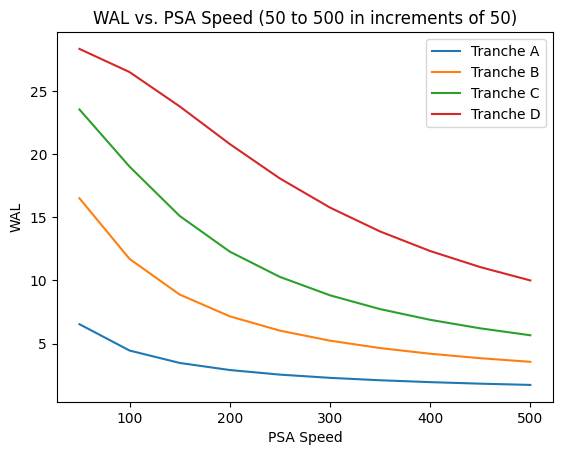

In [16]:
from matplotlib import pyplot as plt
A_wal_list = []
B_wal_list = []
C_wal_list = []
D_wal_list = []

speeds = [x for x in range(50, 550, 50)]

for speed in speeds:
    tranches = {
        'A': 45e6,
        'B': 25e6,
        'C': 20e6,
        'D': 10e6
    }
    sequential = Sequential(principal=100_000_000, WAC=0.065, tranches=tranches)
    sequential.set_psa(speed)
    sequential.calculate_cashflows()
    A_wal_list.append(sequential.tranches_WAL_0['A'])
    B_wal_list.append(sequential.tranches_WAL_0['B'])
    C_wal_list.append(sequential.tranches_WAL_0['C'])
    D_wal_list.append(sequential.tranches_WAL_0['D'])

plt.plot(speeds, A_wal_list, label='Tranche A')
plt.plot(speeds, B_wal_list, label='Tranche B')
plt.plot(speeds, C_wal_list, label='Tranche C')
plt.plot(speeds, D_wal_list, label='Tranche D')
plt.xlabel('PSA Speed')
plt.ylabel('WAL')
plt.title('WAL vs. PSA Speed (50 to 500 in increments of 50)')
plt.legend()
plt.show()

Let us produce a more fine-grained graph.

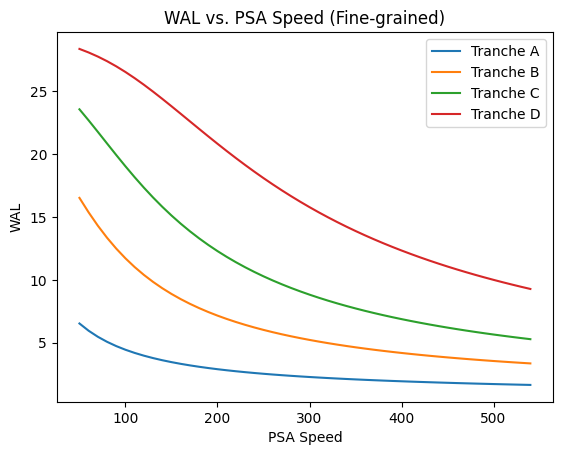

In [17]:
# Fine-grained graph
A_wal_list = []
B_wal_list = []
C_wal_list = []
D_wal_list = []

speeds = [x for x in range(50, 550, 10)]

for speed in speeds:
    tranches = {
        'A': 45e6,
        'B': 25e6,
        'C': 20e6,
        'D': 10e6
    }
    sequential = Sequential(principal=100_000_000, WAC=0.065, tranches=tranches)
    sequential.set_psa(speed)
    sequential.calculate_cashflows()
    A_wal_list.append(sequential.tranches_WAL_0['A'])
    B_wal_list.append(sequential.tranches_WAL_0['B'])
    C_wal_list.append(sequential.tranches_WAL_0['C'])
    D_wal_list.append(sequential.tranches_WAL_0['D'])

plt.plot(speeds, A_wal_list, label='Tranche A')
plt.plot(speeds, B_wal_list, label='Tranche B')
plt.plot(speeds, C_wal_list, label='Tranche C')
plt.plot(speeds, D_wal_list, label='Tranche D')
plt.xlabel('PSA Speed')
plt.ylabel('WAL')
plt.title('WAL vs. PSA Speed (Fine-grained)')
plt.legend()
plt.show()

Calculate the slope from above graph. y-axis is the WAL slop (magnitude) and x-axis is the PSA speed.

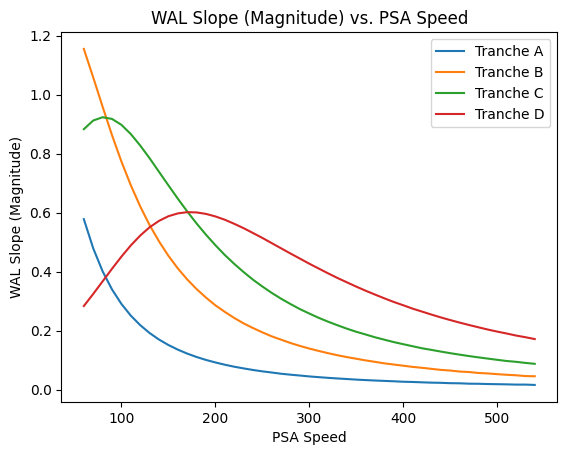

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the change in WAL
A_wal_change = [j-i for i, j in zip(A_wal_list[:-1], A_wal_list[1:])]
B_wal_change = [j-i for i, j in zip(B_wal_list[:-1], B_wal_list[1:])]
C_wal_change = [j-i for i, j in zip(C_wal_list[:-1], C_wal_list[1:])]
D_wal_change = [j-i for i, j in zip(D_wal_list[:-1], D_wal_list[1:])]

# Take the absolute value of the change in WAL
A_wal_change = np.abs(A_wal_change)
B_wal_change = np.abs(B_wal_change)
C_wal_change = np.abs(C_wal_change)
D_wal_change = np.abs(D_wal_change)

# Plot the change in WAL
plt.plot(speeds[1:], A_wal_change, label='Tranche A')
plt.plot(speeds[1:], B_wal_change, label='Tranche B')
plt.plot(speeds[1:], C_wal_change, label='Tranche C')
plt.plot(speeds[1:], D_wal_change, label='Tranche D')
plt.xlabel('PSA Speed')
plt.ylabel('WAL Slope (Magnitude)')
plt.title('WAL Slope (Magnitude) vs. PSA Speed')
plt.legend()
plt.show()

### Conclusion: 

In declining order of sensitivity to PSA speed, the tranches are D > C > B > A.

### WHY?

Since the later tranches are receiving the principal order, the higher WAL the tranches are, which means there are more time expose to prepayment (higher prepayment risk). The effect of prepayment gets accumulated throughout the time, which decreases faster for higher WAL tranches (i.e. later tranches in receiving principal order). However, when sequence is tool long, the effect would be less significant since it is hard to reach until later.


# PCA & Companion

Create a PAC structure with one PAC (with 100 and 250 PSA bands).

In [24]:
from typing import List


class MBS:
    def __init__(self, principal: float, WAC: float, year: int, psa: float):
        self.principal = principal
        self.WAC = WAC
        self.year = year
        self.psa = PSA(psa)
        
    def get_principal_cashflows(self, method = 'prepayment'):
        if method == 'prepayment':
            return self._get_principal_cashflows_prepayment()
        elif method == 'non-prepayment':
            return self._get_principal_cashflows_non_prepayment()
        else:
            raise ValueError("Invalid method")
        
    def _get_principal_cashflows_prepayment(self) -> List[float]:
        df = self._calculate_cashflows_prepayment()
        principal_cashflows = (df["Scheduled Principal Payments"] + df["Unscheduled Principal Payments"]).to_list()
        return principal_cashflows
    
    def _get_principal_cashflows_non_prepayment(self) -> List[float]:
            c = self.WAC / 12
            M0 = self.principal
            # Calculate lifecycle payment schedule
            remaining_principals = [M0]
            interest_payments = []
            principal_payments = []
            monthly_payment = calcualte_monthly_payment(self.principal, self.WAC, self.year * 12)
            for i in range(self.year * 12):
                interest_payment = remaining_principals[i] * c
                principal_payment = monthly_payment - interest_payment
                remaining_principal = remaining_principals[i] - principal_payment
                remaining_principals.append(remaining_principal)
                interest_payments.append(interest_payment)
                principal_payments.append(principal_payment)
            remaining_principals.pop(0)
            return principal_payments
    
    def _calculate_cashflows_prepayment(self) -> pd.DataFrame:
        balance = self.principal
        i = 0
        balances = [balance]
        interest_expenses = [0]
        scheduled_principal_payments = [0]
        unscheduled_principal_payments = [0]
        month_indices = [i]

        scheduled_payment = calcualte_monthly_payment(self.principal, self.WAC, self.year * 12)

        while balance > 0:
            i += 1
            month_indices.append(i)
            interest_payment = cal_monthly_interest_payment(balance, WAC)
            scheduled_principal_payment = scheduled_payment - interest_payment
            if balance < scheduled_principal_payment:
                scheduled_principal_payment = balance
                actual_balance = 0
                unscheduled_principal_payment = 0
            else:
                smm = self.psa.SMM(i)
                prepayment = cal_prepayment(scheduled_balance=balance - scheduled_principal_payment, smm=smm)
                unscheduled_principal_payment = prepayment
                actual_balance = cal_actual_balance(previous_balance=balance,
                                                    scheduled_principal_payment=scheduled_principal_payment,
                                                    prepayment=prepayment)

            balance = actual_balance
            balances.append(balance)
            interest_expenses.append(interest_payment)
            scheduled_principal_payments.append(scheduled_principal_payment)
            unscheduled_principal_payments.append(unscheduled_principal_payment)
            scheduled_payment = scheduled_payment * (1 - smm)

        cashflows = pd.DataFrame({
            "Month": month_indices[1:],
            "Beginning Balance": balances[:-1],
            "Scheduled Principal Payments": scheduled_principal_payments[1:],
            "Unscheduled Principal Payments": unscheduled_principal_payments[1:],
            "Interest Expense": interest_expenses[1:],
            "Unpaid Balance": balances[1:],
            "Paid Principal": [self.principal - x for x in balances[1:]]
        })

        cashflows.set_index("Month", inplace=True)

        return cashflows

In [25]:
from typing import List, Tuple


class PACCOMP:
    def __init__(self, principal: float, WAC: float, year: int, lower_band: float, upper_band: float, psa_speed: float):
        self.principal = principal
        self.WAC = WAC
        self.cashflows = None 
        self.year = year
        self.lower_band = lower_band
        self.upper_band = upper_band
        self.psa = PSA(psa_speed)
        self.PAC_principal = self.PAC_principal()
        self.companion_principal: float = self.principal - self.PAC_principal
        
    
    def PAC_principal(self):
        upper = MBS(principal=self.principal, WAC=self.WAC, year=self.year, psa=self.upper_band)
        lower = MBS(principal=self.principal, WAC=self.WAC, year=self.year, psa=self.lower_band)
        upper_cashflows = upper.get_principal_cashflows(method='prepayment')
        lower_cashflows = lower.get_principal_cashflows(method='prepayment')
        pac_principal_cashflow = [min(x, y) for x, y in zip(upper_cashflows, lower_cashflows)]
        return sum(pac_principal_cashflow)
        
    def calculate_principal_cashflows(self) -> Tuple[List[float], List[float]]:
        pool = MBS(principal=self.principal, WAC=self.WAC, year=self.year, psa=self.psa.speed)
        actual_principal_cashflows = pool.get_principal_cashflows(method='prepayment')
        if 100 <= self.psa.speed <= 250:
            pac_principal_payments = self._calculate_pac_in_bands()
            companion_principal_payments = self.calculate_companion_cashflows(actual_principal_cashflows, pac_principal_payments)
            return pac_principal_payments, companion_principal_payments
        
    def PAC_principal_schedule(self):
        schedule = self._calculate_pac_in_bands()
        return schedule
            
            
        
    def _calculate_pac_in_bands(self) -> List[float]:
        _upper = MBS(principal=self.principal, WAC=self.WAC, year=self.year, psa=self.upper_band)
        _lower = MBS(principal=self.principal, WAC=self.WAC, year=self.year, psa=self.lower_band)
        upper = _upper.get_principal_cashflows(method='prepayment')
        lower = _lower.get_principal_cashflows(method='prepayment')
        pac_principal_cashflow = [min(x, y) for x, y in zip(upper, lower)]
        return pac_principal_cashflow
    
    @staticmethod
    def calculate_companion_cashflows(principal_cashflows: List[float], pac_principal_cashflows: List[float]) -> List[float]:
        max_length = max(len(principal_cashflows), len(pac_principal_cashflows))
        for i in range(max_length):
            if i >= len(principal_cashflows):
                principal_cashflows.append(0)
            if i >= len(pac_principal_cashflows):
                pac_principal_cashflows.append(0)
        companion_principal_cashflows = [x - y for x, y in zip(principal_cashflows, pac_principal_cashflows)]
        return companion_principal_cashflows
    
    @staticmethod
    def plot_principal_cashflows(principal_cashflows: List[float], pac_principal_cashflows: List[float], companion_principal_cashflows: List[float]):
        plt.plot(principal_cashflows, label='Total Principal')
        plt.plot(pac_principal_cashflows, label='PAC Principal')
        # plt.plot(companion_principal_cashflows, label='Companion Principal')
        plt.xlabel('Month')
        plt.ylabel('Principal')
        plt.title('Principal Cashflows')
        plt.legend()
        plt.show()

In [26]:
class PACCOMP_simulation:
    def __init__(self, principal: float, WAC: float, year: int, lower_band: float, upper_band: float):
        self.principal = principal
        self.WAC = WAC
        self.year = year
        self.lower_band = lower_band
        self.upper_band = upper_band
        
        self.pac_comp = PACCOMP(principal=self.principal, WAC=self.WAC, year=self.year, lower_band=self.lower_band, upper_band=self.upper_band, psa_speed=150)
        
        self.month_index = 0
        self.month_indices = []
        
        self._busted = False
        self._pac_done = False
        self._remaining_comp_principal = self.pac_comp.companion_principal

        self._pac_principal_cashflows = []
        self._comp_principal_cashflows = []
        self._total_pac_scheduled = 0
        self._current_pac_total = 0
        self.pac_principal_cashflow_schedule= self.pac_comp.PAC_principal_schedule()
        
        self._pac_notional = self.pac_comp.PAC_principal
        self._comp_notional = self.pac_comp.companion_principal
        
    
    def  inject_payment(self, principal_payment: float):
        self.month_index += 1
        self.month_indices.append(self.month_index)
                #check state
        state = self._get_state()
        self._cache_pac_p = 0
        self._cache_comp_p = 0
        
        self._update_total_pac_scheduled(self.month_index)
        match state:
            case 'EXTENDED_SUPPORT':
                # payment will go to PAC until it is back on schedule i.e. _current_pac_total == self._total_pac_schedule
                self.extend_support_simulate(principal_payment)
            case 'NORMAL':
                # PAC takes schedule payment
                self.normal_simulate(principal_payment)
            case 'BUSTED':
                # payment goes only to PAC
                self.busted_simulate(principal_payment)
            case 'PAC_DONE':
                self.pac_done_simulate(principal_payment)
            
        self._pac_principal_cashflows.append(self._cache_pac_p)
        self._comp_principal_cashflows.append(self._cache_comp_p)
        self._remaining_comp_principal -= self._cache_comp_p
        
        # print(state)
        if self._cache_pac_p < 0:
            # print(state)
            raise ValueError("Negative PAC Payment")
        
            
        # print(f"Month: {self.month_index}, State: {state}")
        

    def _update_total_pac_scheduled(self, i: int):
        # PAC Scheduled starts at month 1,  2, 3
        if i >= len(self.pac_principal_cashflow_schedule)-2:
            self.pac_principal_cashflow_schedule.append(0)
        if not self._pac_done:
            if self._total_pac_scheduled + self.pac_principal_cashflow_schedule[i-1] > self._pac_notional:
                self._total_pac_scheduled = self._pac_notional
            else:
                self._total_pac_scheduled += self.pac_principal_cashflow_schedule[i-1]
        # print("Total PAC Scheduled: ", self._total_pac_scheduled)
        # print("Current PAC Total: ", self._current_pac_total)
        
    def _get_state(self):
        if self._pac_done:
            return 'PAC_DONE'
        if self._current_pac_total < self._total_pac_scheduled:
            return 'EXTENDED_SUPPORT'
        else:
            # Check if busted, if busted then PCA only 
            if self._busted:
                return 'BUSTED'
            else:
                # print("NORMAL", self._current_pac_total, self._total_pac_scheduled)
                return 'NORMAL'
            
    def extend_support_simulate(self, principal_payment):

        if self._current_pac_total + principal_payment >= self._pac_notional:
            remaining_p = principal_payment - (self._pac_notional - self._current_pac_total)
            self._cache_pac_p += (self._pac_notional - self._current_pac_total)
            self.add_payment_to_companion(remaining_p)
            self._current_pac_total = self._pac_notional
            self._pac_done = True
        elif self._current_pac_total + principal_payment >= self._total_pac_scheduled:
            remaining_p = principal_payment - (self._total_pac_scheduled - self._current_pac_total)
            self._cache_pac_p += (self._total_pac_scheduled - self._current_pac_total)
            self.add_payment_to_companion(remaining_p)
            self._current_pac_total = self._total_pac_scheduled
        else:
            self._cache_pac_p += principal_payment
            self._current_pac_total += principal_payment

            
            
    def normal_simulate(self, p: float):
        # pac payment 
        # print("_total_pac_scheduled", self._total_pac_scheduled)
        pac_needed = self._total_pac_scheduled - self._current_pac_total
        # print("pac_needed", pac_needed)
        pac_p = min( pac_needed, p)
        self.add_payment_to_pac(pac_p)
        
        # companion payment 
        comp_p = p - pac_p
        self.add_payment_to_companion(comp_p)
        

    def busted_simulate(self, p: float):
        # PAC only
        self.add_payment_to_pac(p)

    def pac_done_simulate(self, p: float):
        self.add_payment_to_companion(p)
        
        
    def add_payment_to_pac(self, p: float):
        # check if PAC is done
        if self._current_pac_total + p >= self._pac_notional:
            remaining_p = p - (self._pac_notional - self._current_pac_total)
            self._cache_pac_p += (self._pac_notional - self._current_pac_total)
            self.add_payment_to_companion(remaining_p)
            self._current_pac_total = self._pac_notional
            self._pac_done = True
        else:
            self._cache_pac_p += p
            self._current_pac_total += p
        
    def add_payment_to_companion(self, p: float):
        if self._remaining_comp_principal <= p:
            print(self._remaining_comp_principal, p, self._cache_comp_p, self._remaining_comp_principal, self._busted)
            remaining_p = p - self._remaining_comp_principal
            if not self._pac_done:
                self._busted = True
            self._cache_comp_p += self._remaining_comp_principal
            self.add_payment_to_pac(remaining_p)
        else:
            self._cache_comp_p += p
        
    def get_pac_principal_cashflows(self):
        return self._pac_principal_cashflows
    
    def get_companion_principal_cashflows(self):
        return self._comp_principal_cashflows

255689.65231696286 255689.65231704255 0.0 255689.65231696286 False


Text(0.5, 0, 'Month')

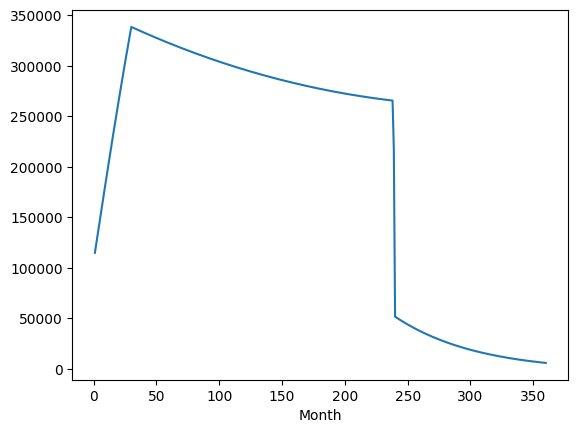

In [27]:
sim_pac_comp = PACCOMP_simulation(principal=100_000_000, WAC=0.065, year=30, lower_band=100, upper_band=250)
pool_psa_100 = MBS(principal=100_000_000, WAC=0.065, year=30, psa=50)

payments = pool_psa_100.get_principal_cashflows(method='prepayment')

for p in payments:
    sim_pac_comp.inject_payment(p)

# plot sim_pac_comp.get_pac_principal_cashflows()
month_indices = sim_pac_comp.month_indices
pac_principal_cashflows = sim_pac_comp.get_pac_principal_cashflows()
comp_principal_cashflows = sim_pac_comp.get_companion_principal_cashflows()

# plot the cashflows
plt.plot(month_indices, pac_principal_cashflows, label='PAC Principal')
plt.xlabel('Month')

## Simulation of PAC & Companion

PSA 50 to PSA 550 in increments of 50

255689.65231696286 255689.65231704255 0.0 255689.65231696286 False


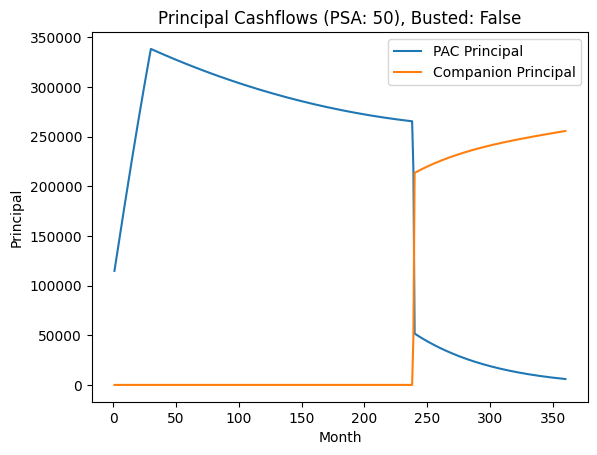

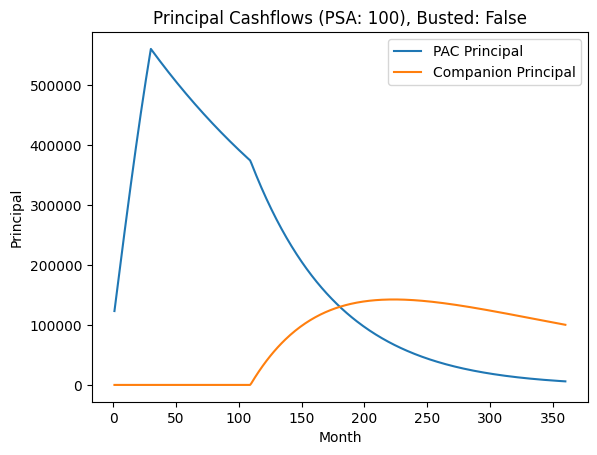

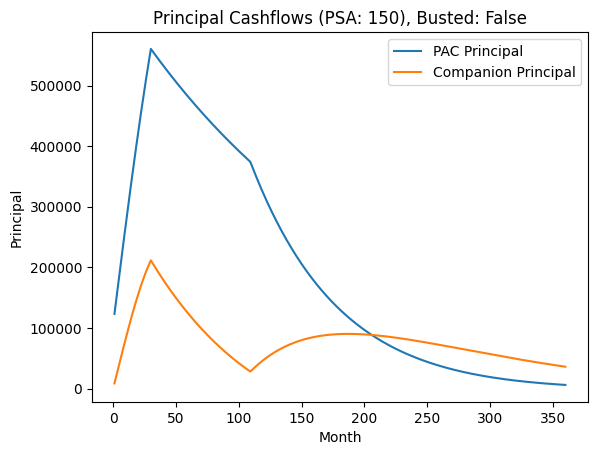

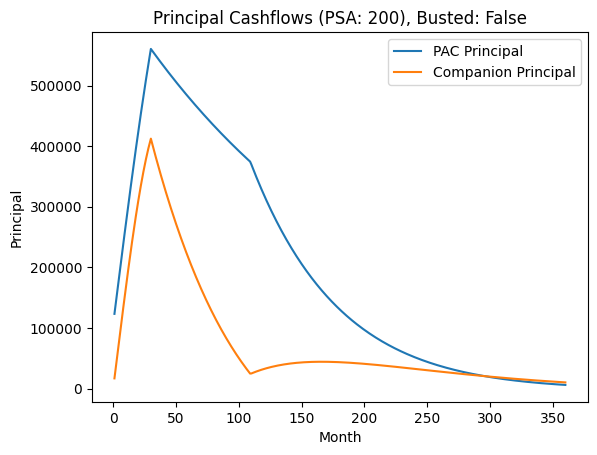

718.3803827890661 718.3803829242243 0 718.3803827890661 False
0.0 1.3817498256685212e-07 0 0.0 True


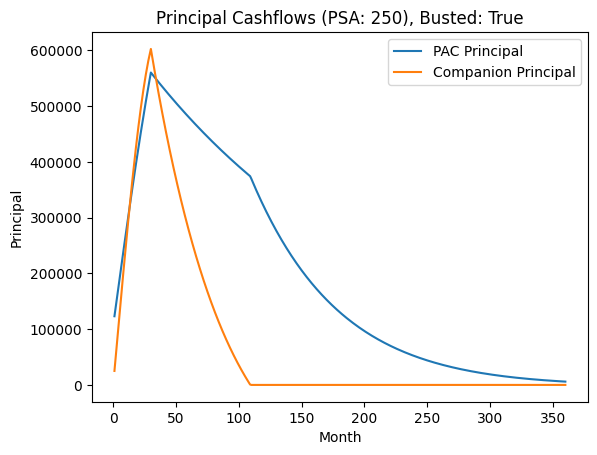

58576.54341436946 330348.1597447903 0 58576.54341436946 False


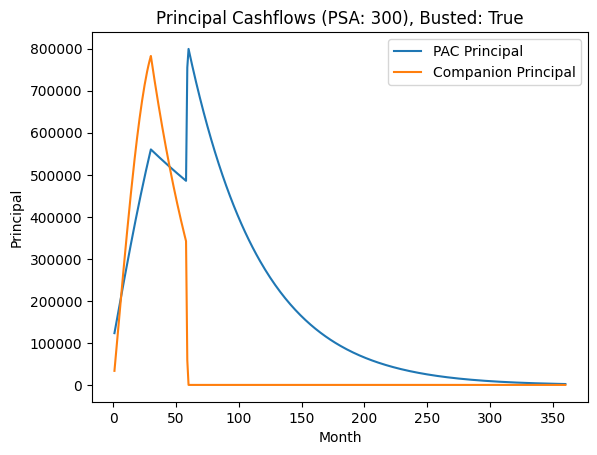

452369.785753408 574793.0033370962 0 452369.785753408 False


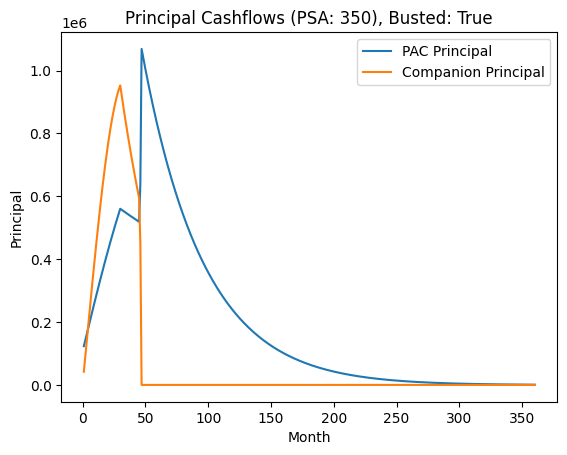

7676.050909031415 787442.0859964597 0 7676.050909031415 False


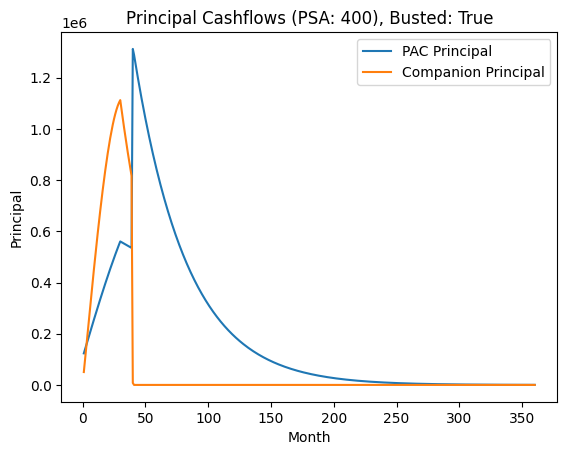

711316.6209554179 1045384.1847549216 0 711316.6209554179 False


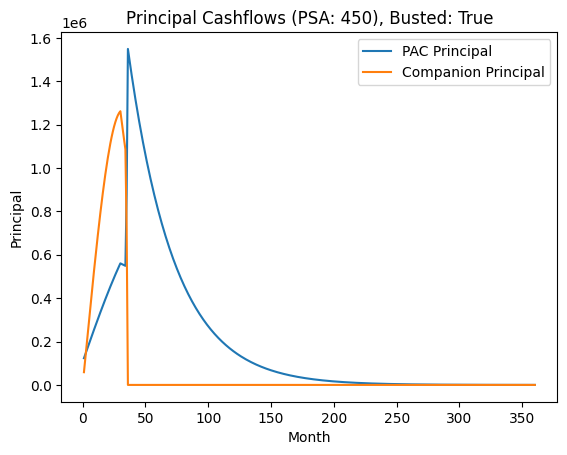

859198.2662917455 1290829.4644252693 0 859198.2662917455 False
0.0 4.654026142247858e-08 0 0.0 True


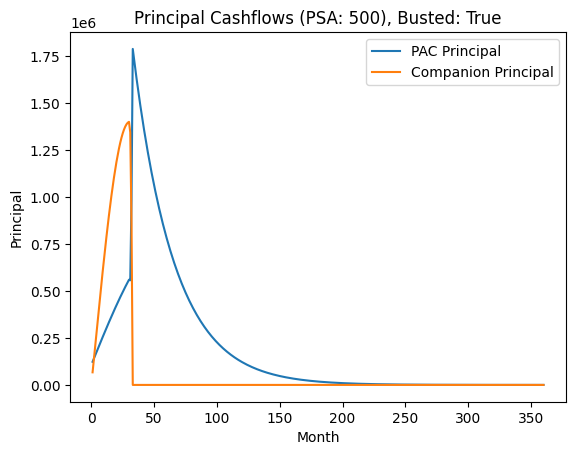

In [28]:
for psa_set in range(50, 550, 50):
    sim_pac_comp = PACCOMP_simulation(principal=100_000_000, WAC=0.065, year=30, lower_band=100, upper_band=250)
    pool_psa_100 = MBS(principal=100_000_000, WAC=0.065, year=30, psa=psa_set)
    
    payments = pool_psa_100.get_principal_cashflows(method='prepayment')
    
    for p in payments:
        sim_pac_comp.inject_payment(p)
    
    # plot sim_pac_comp.get_pac_principal_cashflows()
    month_indices = sim_pac_comp.month_indices
    pac_principal_cashflows = sim_pac_comp.get_pac_principal_cashflows()
    comp_principal_cashflows = sim_pac_comp.get_companion_principal_cashflows()

    #plot the cashflows
    plt.plot(month_indices, pac_principal_cashflows, label='PAC Principal')
    plt.plot(month_indices, comp_principal_cashflows, label='Companion Principal')
    plt.xlabel('Month')
    plt.ylabel('Principal')
    plt.title(f'Principal Cashflows (PSA: {psa_set}), Busted: {sim_pac_comp._busted}')
    plt.legend()
    plt.show()

# Conclusion:

Why PSA scenarios some are busted and some are not?

For PSA 50 to 250, the PAC is not busted because the companion's principal is not fully paid off when the PAC is fully paid off. However, for PSA 300 to 550, the PAC is busted because the companion's principal is fully paid off before the PAC is fully paid off. That is there are more prepayment higher than the 250 upper band, which more quickly decreases the principal of the companion.
